## Change code of Algorithm1 to use known cost vectors

In this notebook I asses how does Algorithm1 behaves when it does not need to estimate feature costs and has an "oracle" access to cost vector.
This will let us determine whether cost estimation is the only reason of poor performance or even if in case of accurate cost knowledge the algorithm fails to outperform baselines.


Here I try to debug the code to find what is the problem.
Spoiler: I seem to have found it, read the text at the end of the notebook.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

In [57]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [58]:
TIME_POINTS = 10000
NUM_FEATURES = 4
N_ARMS = 5
# Beta parameter multiplies the reward achieved by the algorithm
BETA = 1

## Creating context vectors

In [59]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [60]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [61]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1, 2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1, 2, 3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [62]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [63]:
contexts, contexts.shape

(array([[4., 2., 2., 4.],
        [4., 2., 1., 3.],
        [4., 1., 1., 3.],
        ...,
        [2., 2., 1., 4.],
        [1., 2., 1., 4.],
        [2., 2., 1., 4.]]),
 (10000, 4))

### Visualizing context features

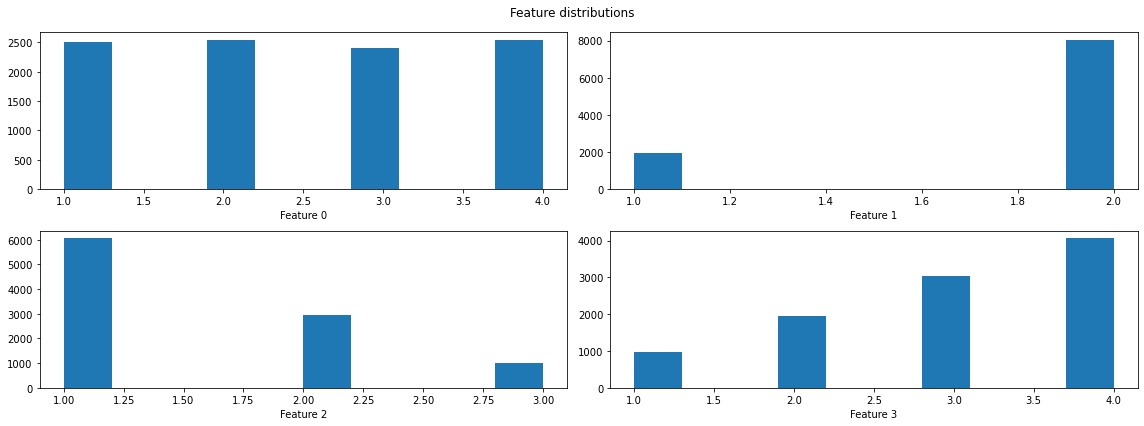

In [64]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [65]:
# Mean of gaussian distribution random in interval
interval_means_raw = np.array([np.random.uniform(0, 0.10, size=(NUM_FEATURES,)) for i in range(5)])

In [66]:
interval_means_raw

array([[0.06433543, 0.00585418, 0.02470971, 0.01538839],
       [0.02906733, 0.03288553, 0.04951968, 0.05201386],
       [0.0630098 , 0.03316521, 0.05320212, 0.09901173],
       [0.02106393, 0.01527058, 0.08425641, 0.04103656],
       [0.08468837, 0.0424689 , 0.00216849, 0.0374873 ]])

In [67]:
interval_means = interval_means_raw * BETA

In [68]:
# Fixed std
interval_stds = [[0.001]*NUM_FEATURES]*5

In [69]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

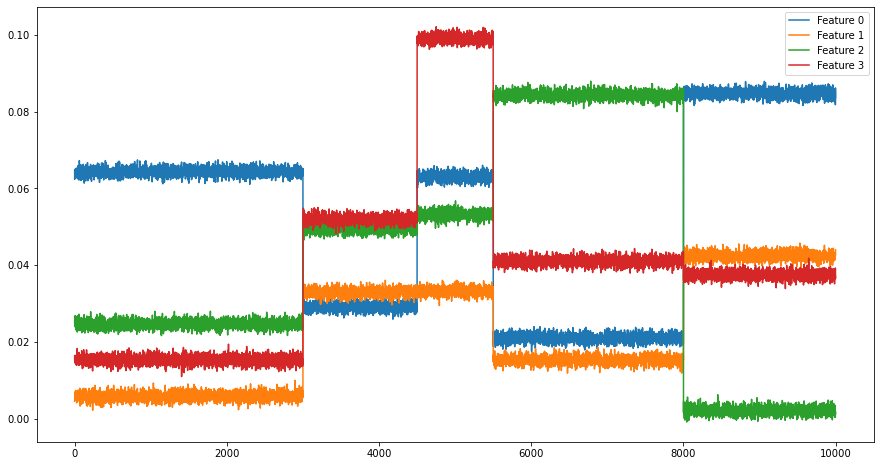

In [70]:
plot_costs(get_costs(), 10000)

In [71]:
costs_obj = get_costs()

In [72]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [73]:
costs_vector.shape

(10000, 4)

## Creating rewards

In [74]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [75]:
slices = [
    slice(0,500),
    slice(500,1000),
    slice(1000,2000),
    slice(2000,3500),
    slice(3500,5000),
    slice(5000,6500),
    slice(6500,8000),
    slice(8000,10000),
]

In [76]:
# old version
reward_config = {
    0: [
        0.28, 0.22 , 0.19 , 0.2 , 0.27 ,
    ],
    1: [
        0.24, 0.7 , 0.2 , 0.27 , 0.25 ,
    ],
    2: [
        0.22, 0.19 , 0.9 , 0.37 , 0.29 ,
    ],
    3: [
        0.36, 0.19 , 0.22 , 0.8 , 0.2 ,
    ],
    4: [
        0.26, 0.27 , 0.28 , 0.34 , 0.94 ,
    ],
    5: [
        0.77, 0.35 , 0.31 , 0.38 , 0.35 ,
    ],
    6: [
        0.2, 0.8 , 0.24 , 0.24 , 0.21 ,
    ],
    7: [
        0.2, 0.22 , 0.9 , 0.37 , 0.29 ,
    ],
}

In [77]:
# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

mean_rewards = np.zeros(rewards.shape)


for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    high_reward_arm = np.random.choice(N_ARMS)
    
    high_reward_arm = i % N_ARMS
    for arm in range(N_ARMS):

        # Use p from config (reward range is config)
#         if arm == high_reward_arm:
#             reward_range = HIGH_REWARD_RANGE
#         else:
#             reward_range = LOW_REWARD_RANGE
        
#         p = np.random.uniform(reward_range[0], reward_range[1])

        p = reward_config[i][arm]

        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )
        
        # for visualization
        mean_rewards[interval_slice, arm] = np.ones(slice_rewards.shape) * np.mean(slice_rewards)

    

Slice 0:
  Arm 0: p=0.28, mean reward=0.27   reward estimated by linear regression 0.27
  Arm 1: p=0.22, mean reward=0.24   reward estimated by linear regression 0.23
  Arm 2: p=0.19, mean reward=0.19   reward estimated by linear regression 0.19
  Arm 3: p=0.20, mean reward=0.20   reward estimated by linear regression 0.19
  Arm 4: p=0.27, mean reward=0.26   reward estimated by linear regression 0.26
Slice 1:
  Arm 0: p=0.24, mean reward=0.25   reward estimated by linear regression 0.24
  Arm 1: p=0.70, mean reward=0.71   reward estimated by linear regression 0.69
  Arm 2: p=0.20, mean reward=0.18   reward estimated by linear regression 0.18
  Arm 3: p=0.27, mean reward=0.26   reward estimated by linear regression 0.25
  Arm 4: p=0.25, mean reward=0.27   reward estimated by linear regression 0.27
Slice 2:
  Arm 0: p=0.22, mean reward=0.22   reward estimated by linear regression 0.21
  Arm 1: p=0.19, mean reward=0.17   reward estimated by linear regression 0.17
  Arm 2: p=0.90, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_56570/2779309452.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


### Visualising rewards

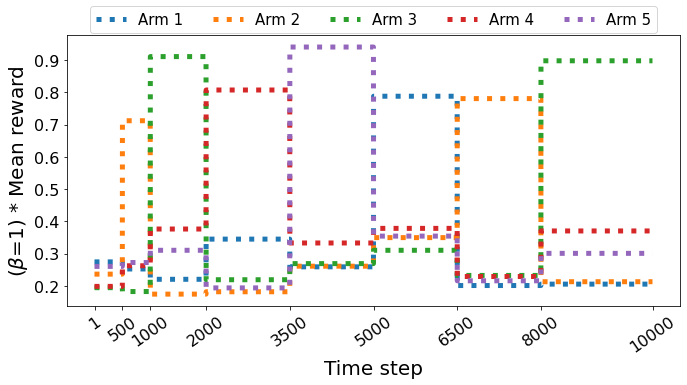

In [78]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(BETA * mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]
plt.xticks(extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Plot reward - sum of feature costs

Min expected gain for arm 1: 0.004013248304766404
Min expected gain for arm 2: 0.006013248304766405
Min expected gain for arm 3: 0.014013248304766412
Min expected gain for arm 4: 0.06046667932907712
Min expected gain for arm 5: 0.024774358661449863


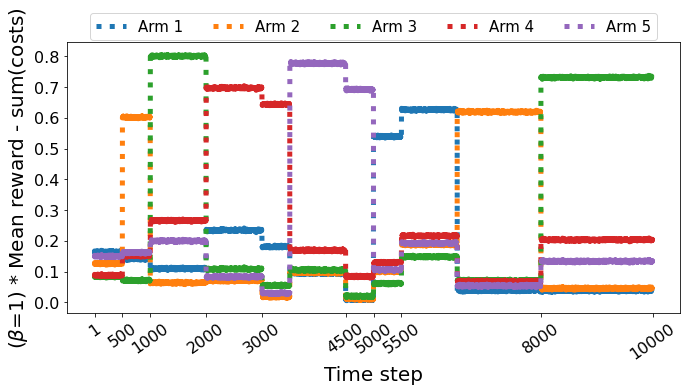

In [79]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 500, 1000, 2000, 3000, 4500, 5000, 5500, 8000, 10000]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [26]:
rewards.shape

(10000, 5)

In [27]:
costs_vector.shape

(10000, 4)

In [28]:
rewards

array([[1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [29]:
data = (contexts, rewards, costs_vector)

In [30]:
# import pickle

# with open('dataset/synthetic/synthetic_data.pickle', 'wb') as f:
#     pickle.dump(data, f)

## Testing algorithms on synthetic data

In [31]:
%load_ext autoreload
%autoreload 2

import algorithms
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
NUM_OF_TRIALS = 10000

In [33]:
NUM_REPETITIONS = 5

In [34]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3709.0
	Total reward: 3709.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3700.0
	Total reward: 3700.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3703.0
	Total reward: 3703.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3769.0
	Total reward: 3769.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3796.0
	Total reward: 3796.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3735.4


In [35]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.1, n_arms=rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.1)
Beta = 1
Total gain: 3934.0
	Total reward: 3934.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 3973.0
	Total reward: 3973.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4411.0
	Total reward: 4411.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4700.0
	Total reward: 4700.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.1)
Beta = 1
Total gain: 4719.0
	Total reward: 4719.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4347.4


In [36]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=0.45,
    )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb
    
gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.45)
Beta = 1
Total gain: 3900.0
	Total reward: 3900.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3900.0


In [37]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.4s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 2327.7035697376323
	Total reward: 3890.0
	Total cost: 1562.2964302623614
Execution time: 0.3s
Average gain: 2327.7035697376323


In [38]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.03,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        contexts,
        rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 5395.703569737655
	Total reward: 6958.0
	Total cost: 1562.2964302623614
Execution time: 0.5s
Average gain: 5395.703569737655


In [39]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=contexts, 
        number_of_actions=rewards.shape[1],
        max_no_red_context=contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.2,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            contexts[:NUM_OF_TRIALS],
            rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0014791488647460938 seconds
Trial 0, time 2022-04-26 21:21:38.838177
Trial 500, time 2022-04-26 21:21:44.154345
Trial 1000, time 2022-04-26 21:21:45.014571
Trial 1500, time 2022-04-26 21:21:46.063684
Trial 2000, time 2022-04-26 21:21:46.484585
Trial 2500, time 2022-04-26 21:21:46.809433
Trial 3000, time 2022-04-26 21:21:47.146714
Trial 3500, time 2022-04-26 21:21:47.521627
Trial 4000, time 2022-04-26 21:21:47.953411
Trial 4500, time 2022-04-26 21:21:48.404529
Trial 5000, time 2022-04-26 21:21:48.535497
Trial 5500, time 2022-04-26 21:21:49.118210
Trial 6000, time 2022-04-26 21:21:49.498589
Trial 6500, time 2022-04-26 21:21:49.628587
Trial 7000, time 2022-04-26 21:21:49.753852
Trial 7500, time 2022-04-26 21:21:49.976811
Trial 8000, time 2022-04-26 21:21:51.849111
Trial 8500, time 2022-04-26 21:21:52.577993
Trial 9000, time 2022-04-26 21:21:52.705197
Trial 9500, time 2022-04-26 21:21:52.831367
SimOOS (beta=1, delta=0.2)
Beta = 1
Total gain: 4090.988420382367
	Total reward: 4798.0
	

In [40]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=contexts, 
        number_of_actions=rewards.shape[1],
        max_no_red_context=contexts.shape[1],
        beta=BETA,
        delta=0.12,
        window_length=500,
        oracle_costs=True,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            contexts[:NUM_OF_TRIALS],
            rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0015070438385009766 seconds
Round 0, time 2022-04-26 21:23:01.473463
Round 500, time 2022-04-26 21:23:36.079731
Round 1000, time 2022-04-26 21:24:15.392432
Round 1500, time 2022-04-26 21:24:54.656093
Round 2000, time 2022-04-26 21:25:33.792100
Round 2500, time 2022-04-26 21:26:12.989884
Round 3000, time 2022-04-26 21:26:52.168944
Round 3500, time 2022-04-26 21:27:31.384690
Round 4000, time 2022-04-26 21:28:10.420849
Round 4500, time 2022-04-26 21:28:49.820752
Round 5000, time 2022-04-26 21:29:28.944239
Round 5500, time 2022-04-26 21:30:08.129160
Round 6000, time 2022-04-26 21:30:47.345345
Round 6500, time 2022-04-26 21:31:26.543570
Round 7000, time 2022-04-26 21:32:05.627171
Round 7500, time 2022-04-26 21:32:44.850727
Round 8000, time 2022-04-26 21:33:24.084266
Round 8500, time 2022-04-26 21:34:03.181882
Round 9000, time 2022-04-26 21:34:42.326107
Round 9500, time 2022-04-26 21:35:21.409087
Algorithm1 (beta=1, delta=0.12, w=500)
Beta = 1
Total gain: 5199.190890138076
	Total rewa

### Plot cumulative gain

In [80]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind % 7]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]
    plt.xticks( extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    
    plt.legend(prop={'size': 16});
#     plt.savefig('gain_synthetic.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

    
    plt.show();

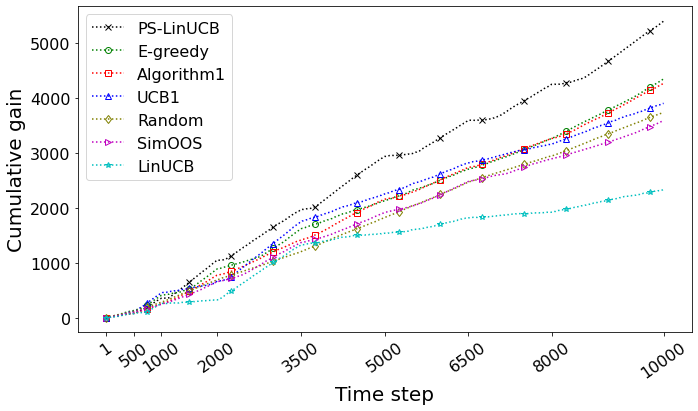

In [81]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


In [43]:
p_alg1.random_actions

4396

In [44]:
list(p_alg1.nus)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.

In [45]:
list(p_alg1.selected_action_SimOOS)

[2.0,
 2.0,
 0.0,
 1.0,
 2.0,
 0.0,
 3.0,
 4.0,
 2.0,
 0.0,
 2.0,
 0.0,
 0.0,
 4.0,
 4.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 0.0,
 1.0,
 3.0,
 1.0,
 4.0,
 0.0,
 4.0,
 1.0,
 0.0,
 0.0,
 2.0,
 1.0,
 1.0,
 1.0,
 3.0,
 2.0,
 2.0,
 3.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 4.0,
 1.0,
 0.0,
 3.0,
 4.0,
 4.0,
 1.0,
 1.0,
 3.0,
 2.0,
 2.0,
 4.0,
 3.0,
 4.0,
 2.0,
 1.0,
 4.0,
 3.0,
 1.0,
 0.0,
 1.0,
 4.0,
 2.0,
 1.0,
 3.0,
 0.0,
 4.0,
 4.0,
 0.0,
 1.0,
 4.0,
 4.0,
 1.0,
 3.0,
 4.0,
 3.0,
 2.0,
 2.0,
 3.0,
 1.0,
 4.0,
 3.0,
 1.0,
 3.0,
 3.0,
 4.0,
 0.0,
 1.0,
 4.0,
 3.0,
 3.0,
 0.0,
 4.0,
 3.0,
 1.0,
 4.0,
 3.0,
 1.0,
 4.0,
 4.0,
 2.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 3.0,
 4.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 4.0,
 4.0,
 4.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 4.0,
 4.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0

In [46]:
list(p_alg1.selected_context_SimOOS[:])

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 1.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 1.]),
 array([0., 1., 0., 0.]),
 array([0., 1., 0., 1.]),
 array([0., 1., 1., 0.]),
 array([0., 1., 1., 1.]),
 array([1., 0., 0., 0.]),
 array([1., 0., 0., 1.]),
 array([1., 0., 1., 0.]),
 array([1., 0., 1., 1.]),
 array([1., 1., 0., 0.]),
 array([1., 1., 0., 1.]),
 array([1., 1., 1., 0.]),
 array([1., 1., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 1., 1.]),
 array([0., 

In [47]:
list(p_alg1.costs)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.06504665, 0.00664752, 0.02436099, 0.01492603]),
 array([0.0651934 , 0.00566287, 0.02343403, 0.0142551 ]),
 array([0.06341598, 0.00635134, 0.02485214, 0.01607887]),
 array([0.06390818, 0.00601272, 0.0253353 , 0.01507904]),
 array([0.0647922 , 0.00519225, 0.02434666, 0.01500665]),
 array([0.06313959, 0.00634115, 0.02424031, 0.01540088]),
 array([0.06481617, 0.00630071, 0.0253751 , 0.0152899 ]),
 array([0.06391213, 0.00577446, 0.02302238, 0.01394127]),
 array([0.06301273, 0.00485693, 0.02510949, 0.01448291]),
 array([0.06395727, 0.00715341, 0.02435345, 0.0161259 ]),
 arr

In [48]:
list(p_alg1.c_hats)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.06402261, 0.00577253, 0.02515018, 0.01527402]),
 array([0.06402261, 0.00577253, 0.02506249, 0.01523535]),
 array([0.0641527 , 0.00576035, 0.02489964, 0.01513733]),
 array([0.06407903, 0.00581945, 0.02489532, 0.01522292]),
 array([0.0640635 , 0.00583702, 0.02493199, 0.01521093]),
 array([0.06412422, 0.00578329, 0.02488696, 0.01519522]),
 array([0.06412422, 0.00578329, 0.02484077, 0.01520991]),
 array([0.06412422, 0.00578329, 0.02487639, 0.01521524]),
 array([0.06412422, 0.00578329, 0.02476052, 0.01513562]),
 array([0.06412422, 0.00578329, 0.02478105, 0.01509722]),
 arr

In [49]:
list(p_alg1.cost_conf_int)

[array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([1.08775877, 1.08775877, 1.08775877, 1.08775877]),
 array([1.08775877, 1.08775877, 1.02554881, 1.02554881]),
 array([1.02554881, 1.02554881, 0.97292102, 0.97292102]),
 array([0.97292102, 0.97292102, 0.9276438 , 0.9276438 ]),
 array([0.9276438 , 0.9276438 , 0.88815132, 0.88815132]),
 array([0.88815132, 0.88815132, 0.85330819, 0.85330819]),
 array([0.88815132, 0.88815132, 0.82226834, 0.82226834]),
 array([0.88815132, 0.88815132, 0.79438669, 0.79438669]),
 array([0.88815132, 0.88815132, 0.7691616 , 0.7691616 ]),
 array([0.88815132, 0.88815132, 0.74619636, 0.74619636]),
 arr

## Debugging

## PS-LinUCB for comparison

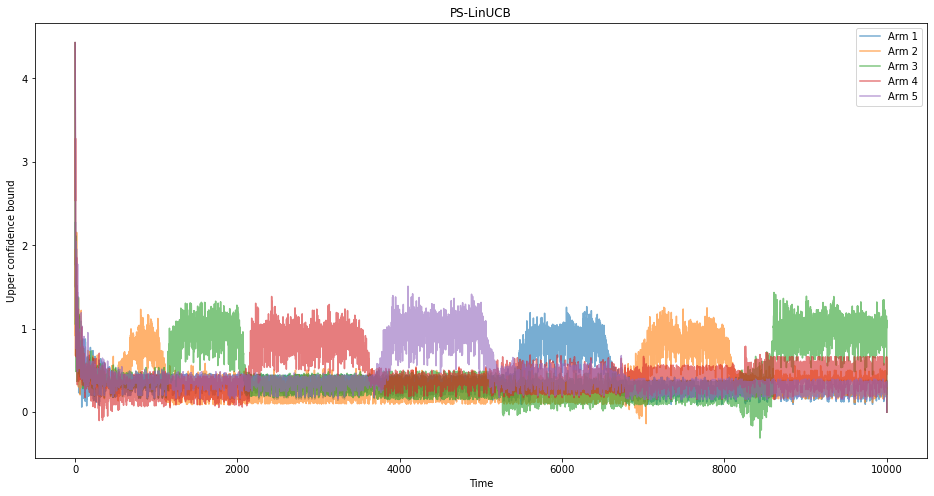

In [50]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(ps_linucb.ucbs[:, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('PS-LinUCB');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

In [51]:
# fig, ax = plt.subplots(1,1, figsize=(16, 8))
# for i in range(5):
#     ax.plot(ps_linucb.rewards[:, i], label=f"Arm {i+1}", alpha=0.6);
# ax.set_title('PS-LinUCB - rewards');
# ax.set_xlabel('Time');
# ax.set_ylabel('Upper confidence bound');
# plt.legend();

In [52]:


# fig, ax = plt.subplots(5,1, figsize=(15, 15))
# fig.suptitle('Upper confidence bounds for PS-LinUCB')
# for i in range(5):
#     ax[i].plot(ps_linucb.ucbs[:NUM_OF_TRIALS, i], color=plt.cm.tab10(i));
#     ax[i].set_title(f"PS-LinUCB - arm {i+1}");
#     ax[i].set_ylabel('Upper confidence bound');
#     ax[i].set_ylim([0.0, 2.3])

# plt.tight_layout();

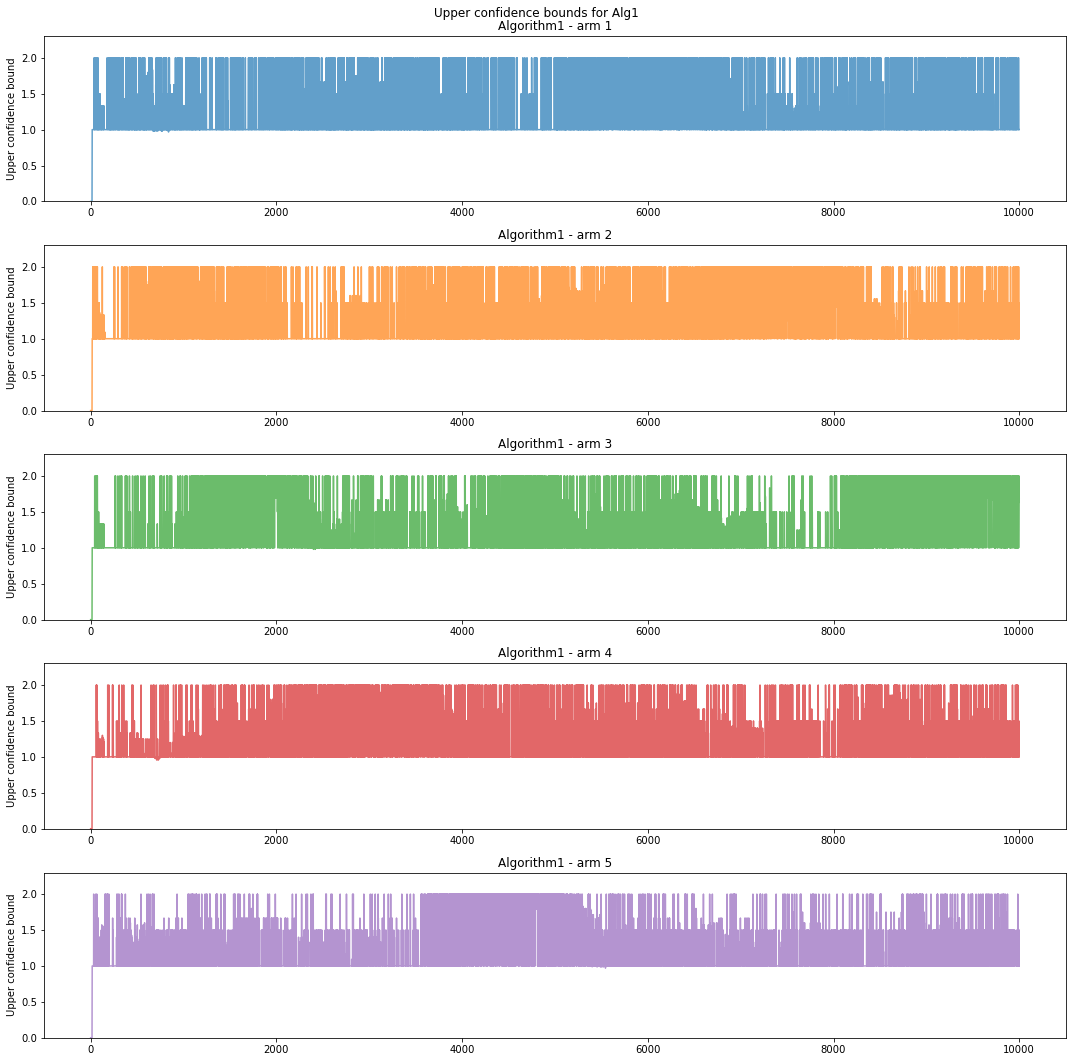

In [82]:


fig, ax = plt.subplots(5,1, figsize=(15, 15))
fig.suptitle('Upper confidence bounds for Alg1')
for i in range(5):
    ax[i].plot(p_alg1.ucbs[:NUM_OF_TRIALS, i], color=plt.cm.tab10(i), alpha=0.7);
    ax[i].set_title(f"Algorithm1 - arm {i+1}");
    ax[i].set_ylabel('Upper confidence bound');
    ax[i].set_ylim([0.0, 2.3])

plt.tight_layout();

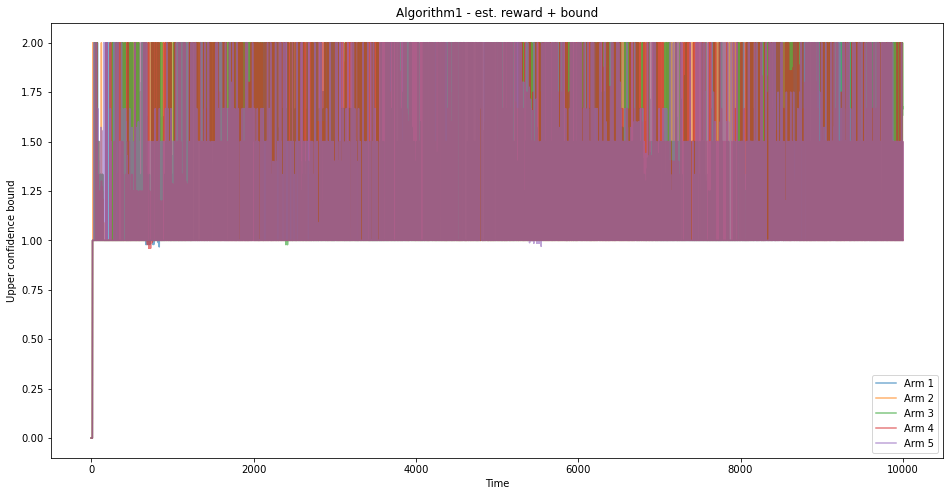

In [54]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(p_alg1.ucbs[:NUM_OF_TRIALS, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('Algorithm1 - est. reward + bound');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

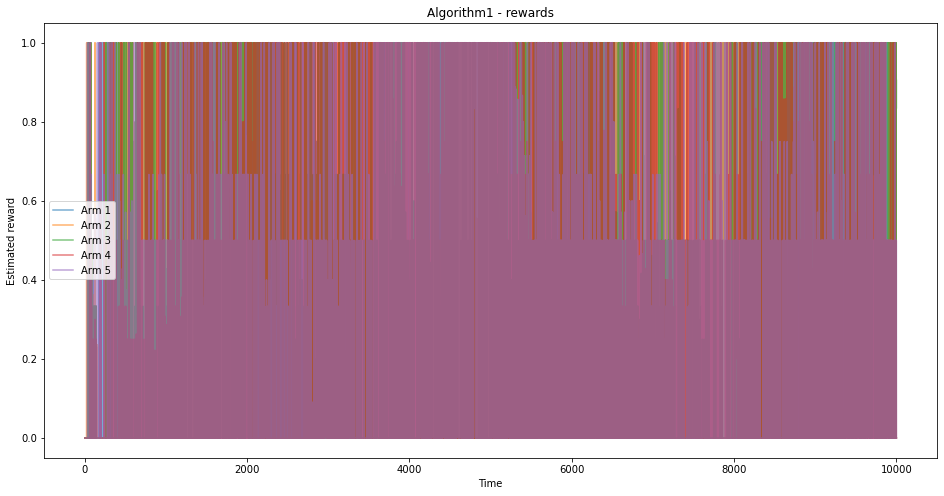

In [55]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(p_alg1.rewards[:NUM_OF_TRIALS, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('Algorithm1 - rewards');
ax.set_xlabel('Time');
ax.set_ylabel('Estimated reward');
plt.legend();

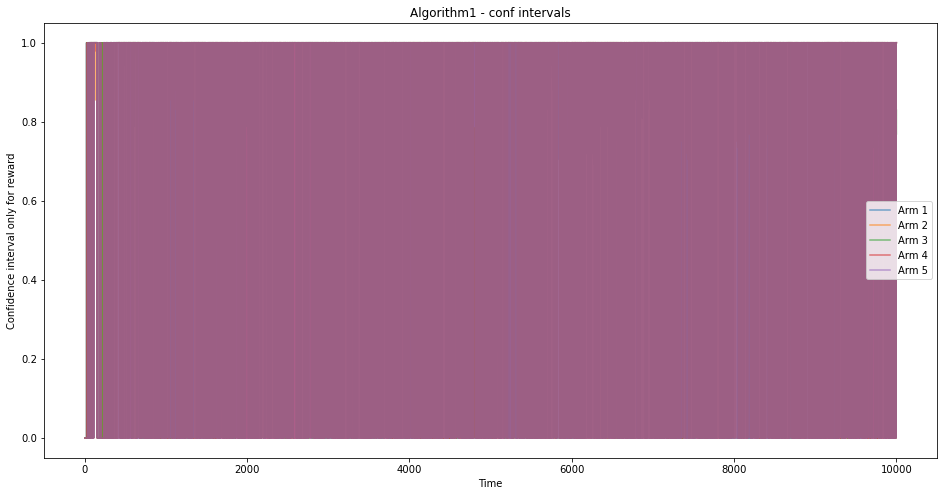

In [56]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(p_alg1.confidences[:NUM_OF_TRIALS, i], label=f"Arm {i+1}", alpha=0.6);
ax.set_title('Algorithm1 - conf intervals');
ax.set_xlabel('Time');
ax.set_ylabel('Confidence interval only for reward');
plt.legend();

I found an apparent bug in the code:
In this commit:
https://github.com/SaeedGhoorchian/costly_nonstationary_bandits/commit/8db7c16665eb28ed87ffa63ddda5d8f1cc6ed2fd#diff-427612d30394461253511a5de400852f2b83d07df2e59cf256d38f93924f4b0cR283
I added the min(1, value) operation to computing the N_t_aso, but several other places in the code were critically dependant on seeing zeros inside N_t_aso. These parts of the code influenced the exploration of the algorithm. 
So I changed the update of N_t_aso here:
https://github.com/SaeedGhoorchian/costly_nonstationary_bandits/commit/3907b9621153c447be17925879e98d8f9e6f6cdb

Let's see how the result plays out.